In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [35]:
df = pd.read_csv('NewsCategorizer.csv')
df = df[['category', 'short_description']]
category_list = ['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'SPORTS', 'WELLNESS']
df = df.loc[df['category'].isin(category_list)]
df

,category,short_description
0,WELLNESS,Resting is part of training. I've confirmed wh...
1,WELLNESS,Think of talking to yourself as a tool to coac...
2,WELLNESS,The clock is ticking for the United States to ...
3,WELLNESS,"If you want to be busy, keep trying to be perf..."
4,WELLNESS,"First, the bad news: Soda bread, corned beef a..."
...,...,...
49995,SPORTS,Many fans were pissed after seeing the minor l...
49996,SPORTS,"Never change, young man. Never change."
49997,SPORTS,Wallace was hit with a first technical for a h...
49998,SPORTS,They believe CBD could be an alternative to po...


In [36]:
df['category'] = df['category'].astype('category').cat.codes
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,category,short_description
0,4,Resting is part of training. I've confirmed wh...
1,4,Think of talking to yourself as a tool to coac...
2,4,The clock is ticking for the United States to ...
3,4,"If you want to be busy, keep trying to be perf..."
4,4,"First, the bad news: Soda bread, corned beef a..."
...,...,...
49995,3,Many fans were pissed after seeing the minor l...
49996,3,"Never change, young man. Never change."
49997,3,Wallace was hit with a first technical for a h...
49998,3,They believe CBD could be an alternative to po...


In [37]:
description = df['short_description'].values
category = df['category'].values
desc_train, desc_test, cate_train, cate_test = train_test_split(description, category, test_size=0.2)

In [38]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(desc_train) 
tokenizer.fit_on_texts(desc_test)
 
sequence_train = tokenizer.texts_to_sequences(desc_train)
sequence_test = tokenizer.texts_to_sequences(desc_test)
 
padded_train = pad_sequences(sequence_train, maxlen=200, padding='post', truncating='post') 
padded_test = pad_sequences(sequence_test, maxlen=200, padding='post', truncating='post')

print(tokenizer.word_index)

{'<OOV>': 1, 'the': 2, 'to': 3, 'a': 4, 'of': 5, 'and': 6, 'in': 7, 'is': 8, 'that': 9, 'for': 10, 'on': 11, 'it': 12, 'you': 13, 'with': 14, 'are': 15, 'i': 16, 'as': 17, 'be': 18, 'this': 19, 'we': 20, 'have': 21, 'but': 22, 'at': 23, 'was': 24, 'not': 25, 'your': 26, 'from': 27, 'an': 28, 'has': 29, 'by': 30, 'or': 31, 'about': 32, 'more': 33, 'can': 34, 'what': 35, 'his': 36, 'our': 37, 'will': 38, 'one': 39, 'their': 40, 'they': 41, 'all': 42, 'new': 43, 'when': 44, 'he': 45, 'who': 46, 'if': 47, "it's": 48, 'time': 49, 'my': 50, 'up': 51, 'do': 52, 'out': 53, 'people': 54, 'just': 55, 'so': 56, 'how': 57, 'her': 58, 'been': 59, 'like': 60, 'some': 61, 'than': 62, 'there': 63, 'no': 64, 'most': 65, 'after': 66, 'year': 67, 'first': 68, 'life': 69, 'its': 70, 'get': 71, 'into': 72, 'us': 73, 'would': 74, 'many': 75, 'had': 76, 'over': 77, 'years': 78, 'now': 79, 'she': 80, 'even': 81, 'were': 82, 'day': 83, 'make': 84, 'also': 85, 'two': 86, 'only': 87, 'said': 88, 'way': 89, 'may'

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.75):
      print("\nReached 80% accuracy")
      self.model.stop_training = True
callbacks = myCallback()

In [41]:
num_epochs = 100
history = model.fit(padded_train,
                    cate_train,
                    epochs=num_epochs, 
                    validation_data=(padded_test, cate_test),
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/100
625/625 [==============================] - 14s 18ms/step - loss: 1.2184 - accuracy: 0.4548 - val_loss: 0.9568 - val_accuracy: 0.6008
Epoch 2/100
625/625 [==============================] - 10s 17ms/step - loss: 0.7169 - accuracy: 0.7290 - val_loss: 0.7127 - val_accuracy: 0.7366
Epoch 3/100
625/625 [==============================] - 10s 16ms/step - loss: 0.4958 - accuracy: 0.8300 - val_loss: 0.7041 - val_accuracy: 0.7478
Epoch 4/100
625/625 [==============================] - 10s 17ms/step - loss: 0.3809 - accuracy: 0.8711 - val_loss: 0.7534 - val_accuracy: 0.7470
Epoch 5/100
622/625 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.9011
Reached 80% accuracy
625/625 [==============================] - 10s 17ms/step - loss: 0.2994 - accuracy: 0.9011 - val_loss: 0.8198 - val_accuracy: 0.7524


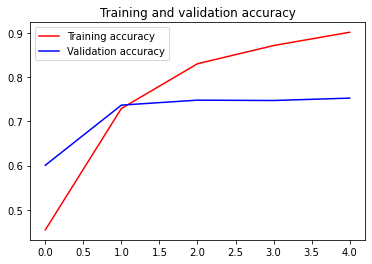

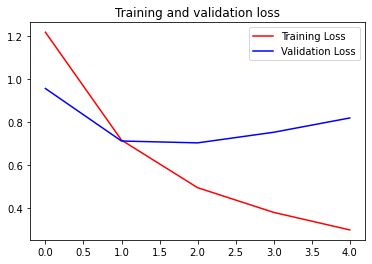

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
text_prediction = "The Witcher 3 next gen upgrade is finally back on the calendar"

sequence_pred = tokenizer.texts_to_sequences([text_prediction])
print(sequence_pred)

padded_pred = pad_sequences(sequence_pred, maxlen=len(sequence_pred[0]), padding='post', truncating='post') 
print(padded_pred)

result_pred = model.predict(padded_pred)
class_pred = category_list[np.argmax(result_pred)]
print("\nCategory Result: ", class_pred)

[[2, 1, 314, 210, 1, 1, 8, 541, 117, 11, 2, 3875]]
[[   2    1  314  210    1    1    8  541  117   11    2 3875]]

Category Result:  ENTERTAINMENT
